In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Section A: Equiprobability

### Question 1
Check that equiprobability is satisfied in **direct_disks_box.py**. Check it not for all legal configurations, but for the three configurations (a, b, c) shown below. The probability to hit any of these configurations exactly is of course zero, so we must put little boxes around them, as shown in red:

<img src="Section 1.png"/>

Using small boxes $[x - \delta_{xy}, x + \delta_{xy}]$, etc, modify the program **direct_disks_box_multirun.py** to show that the probability to sample configurations a, b, and c are the same (within the numerical precision), with

In [98]:
a = ((0.30, 0.30), (0.30, 0.70), (0.70, 0.30), (0.70,0.70))
b = ((0.20, 0.20), (0.20, 0.80), (0.75, 0.25), (0.75,0.75))
c = ((0.30, 0.20), (0.30, 0.80), (0.70, 0.20), (0.70,0.70))

### Solution

In [3]:
def draw_circle(coord, radius):
    fig, ax = plt.subplots()
    for x in coord:
        c = plt.Circle(x, radius) 
        ax.add_artist(c)
    
    plt.show()

In [4]:
def sample_disks(balls, radius):
    coords = np.random.uniform(low = radius, high = 1-radius, size=(balls, 2))
    
    for i in range(coords.shape[0]):
        for j in range(i, coords.shape[0]):
            if np.sum((coords[0] - coords[1])**2) < 2*radius:
                return sample_disks(balls, radius)
    return coords

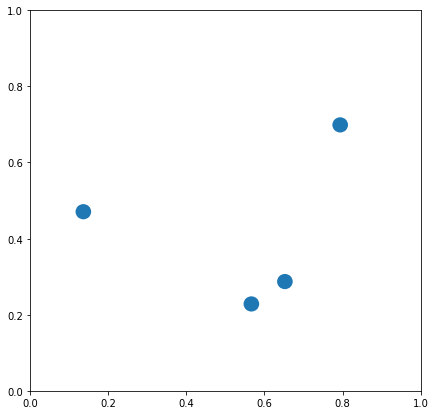

In [5]:
plt.rcParams['figure.figsize'] = [7, 7]

draw_circle(sample_disks(4, 0.02), 0.02)

In [6]:
conf_a = np.array(a)
conf_b = np.array(b)
conf_c = np.array(c)

hits = {"conf_A":0, "conf_B":0, "conf_C":0}

eta = 0.05
balls = 4
radius = 0.15
runs = int(1e6)

In [7]:
# Sampling of to compare results.

for x in range(1, runs+1):
    sample_points = sample_disks(balls, radius)

    hits["conf_A"] += (np.max(np.abs(sample_points - conf_a)) < eta)
    hits["conf_B"] += (np.max(np.abs(sample_points - conf_b)) < eta)
    hits["conf_C"] += (np.max(np.abs(sample_points - conf_c)) < eta)
    
    if x in [int(1e1), int(1e2), int(1e3), int(1e4), int(1e5), int(1e6)]:
        print("For {} samples: {}".format(x, hits))

For 10 samples: {'conf_A': 0, 'conf_B': 0, 'conf_C': 0}
For 100 samples: {'conf_A': 0, 'conf_B': 0, 'conf_C': 0}
For 1000 samples: {'conf_A': 0, 'conf_B': 0, 'conf_C': 0}
For 10000 samples: {'conf_A': 0, 'conf_B': 0, 'conf_C': 0}
For 100000 samples: {'conf_A': 0, 'conf_B': 0, 'conf_C': 0}
For 1000000 samples: {'conf_A': 0, 'conf_B': 1, 'conf_C': 1}


In [8]:
conf_a = np.array(a)
conf_b = np.array(b)
conf_c = np.array(c)

hits = {"conf_A":0, "conf_B":0, "conf_C":0}

eta = 0.10
balls = 4
radius = 0.15
runs = int(1e6)

In [9]:
for x in range(1, runs+1):
    sample_points = sample_disks(balls, radius)

    hits["conf_A"] += (np.max(np.abs(sample_points - conf_a)) < eta)
    hits["conf_B"] += (np.max(np.abs(sample_points - conf_b)) < eta)
    hits["conf_C"] += (np.max(np.abs(sample_points - conf_c)) < eta)
    
    if x in [int(1e1), int(1e2), int(1e3), int(1e4), int(1e5), int(1e6)]:
        print("For {} samples: {}".format(x, hits))

For 10 samples: {'conf_A': 0, 'conf_B': 0, 'conf_C': 0}
For 100 samples: {'conf_A': 0, 'conf_B': 0, 'conf_C': 0}
For 1000 samples: {'conf_A': 0, 'conf_B': 0, 'conf_C': 0}
For 10000 samples: {'conf_A': 0, 'conf_B': 0, 'conf_C': 0}
For 100000 samples: {'conf_A': 0, 'conf_B': 5, 'conf_C': 3}
For 1000000 samples: {'conf_A': 15, 'conf_B': 58, 'conf_C': 62}


Here all the points are configuration ie. each 8-dimensional points are sampled independently. But due to that sometime, such configurations are sampled which violates the overlapping constraints, but those configurations are rejected and the point is resampled until it doesn't violate the constraints.
If the sampling was done as a chain, only the sampling os seed would be independent and the rest of the points will be conditioned on that first point and the probability of the sample will not be equiprobable each participant of the set of all possible configuration.

### Question 2

Analogously, check equiprobability of the configurations a, b, and c of Section A1, for the algorithm markov_disks_box.py

Compare with the analogous problem in Section A1: You might observe larger fluctuations of the results. Is that at all possible, given that Markov-chain sampling and Direct sampling should yield the same results?

### Solution

In [51]:
def sample_disks_markov(balls, radius, delta):
    points = [np.random.uniform(low=radius, high=1-radius, size=(1,2))]
    
    while len(points)<balls:
        n_point = points[-1] + np.random.uniform(low=-delta, high=delta, size=(1,2))
        if np.min(n_point) >= radius and np.max(n_point) <= 1-radius:
            points.append(n_point)
    
    points = np.squeeze(np.array(points))

    for i in range(points.shape[0]):
        for j in range(i, points.shape[0]):
            if np.sum((points[0] - points[1])**2) < 2*radius:
                return sample_disks_markov(balls, radius, delta)
    return points

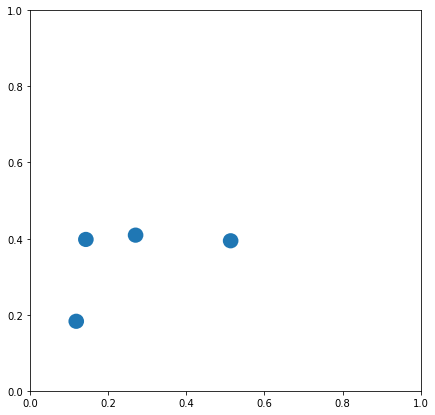

In [58]:
plt.rcParams['figure.figsize'] = [7, 7]

draw_circle(sample_disks_markov(4, 0.02, 0.4), 0.02)

In [85]:
conf_a = np.array(a)
conf_b = np.array(b)
conf_c = np.array(c)

hits = {"conf_A":0, "conf_B":0, "conf_C":0}

eta = 0.12
balls = 4
radius = 0.10
delta = 0.5
runs = int(1e6)

In [86]:
# Sampling to compare results.

for x in range(1, runs+1):
    sample_points = sample_disks_markov(balls, radius, delta)

    hits["conf_A"] += (np.max(np.abs(sample_points - conf_a)) < eta)
    hits["conf_B"] += (np.max(np.abs(sample_points - conf_b)) < eta)
    hits["conf_C"] += (np.max(np.abs(sample_points - conf_c)) < eta)
    
    if x in [int(1e1), int(1e2), int(1e3), int(1e4), int(1e5), int(1e6)]:
        print("For {} samples: {}".format(x, hits))

For 10 samples: {'conf_A': 0, 'conf_B': 0, 'conf_C': 0}
For 100 samples: {'conf_A': 0, 'conf_B': 0, 'conf_C': 0}
For 1000 samples: {'conf_A': 0, 'conf_B': 0, 'conf_C': 0}
For 10000 samples: {'conf_A': 0, 'conf_B': 0, 'conf_C': 0}
For 100000 samples: {'conf_A': 0, 'conf_B': 0, 'conf_C': 1}
For 1000000 samples: {'conf_A': 0, 'conf_B': 0, 'conf_C': 22}


Markov-chain sampling and Direct sampling could yield the same results but for very large numbers of runs because in Markov Chain sampling many samples are rejected and that can be compensated by collecting a large number of samples.

Markov chain sampling can result in equiprobability states only if the jump size if space from which has to be sampled is a subset of the set of points which can be sampled at any time instant t in the Markov Chain sampling which is possible only if the jump size is large enough that it over the whole space from which sampling has to be done.

In case of relatively small jump size, as compared to the dimension of the space, all the points of space may not equally probable.

### Question 3

Consider the program event_disks_box.py.

Prove, without any numerical simulations, that no event-configuration will count for the configurations a, b, c of Section A1. Show that this means that the event positions are not equally probable (Note that this is rather natural).

Modify the program event_disks_box.py, so that it determines the configurations at constant time intervals, t=0, Delta t, 2 Delta t, 3 Delta t,.. It is for these configurations that equal probability should be valid.

Note that in this program, we use del_xy = 0.1, and sigma = 0.1, in order to improve statistics.

Then do the following:

+ First answer the question about event-configurations from the beginning of the section.
+ Run the program for 5,000,000 events, write down how many times you were close to a, b, and c. (choose smaller number of events, if you cannot run that long). Do you get an indication in favor of equiprobability?
+ What is the total running time at the end of the simulation, and at what times are the configurations analyzed (is it at time 0,1,2,3,... or at times 0,2,4,6,... or at times 0, 0.1, 0.2, 0.3....?). (Hint: put print statements to find out).

### Solution

In [117]:
import math

def wall_time(pos_a, vel_a, sigma):
    if vel_a > 0.0:
        del_t = (1.0 - sigma - pos_a) / vel_a
    elif vel_a < 0.0:
        del_t = (pos_a - sigma) / abs(vel_a)
    else:
        del_t = float('inf')
    return del_t

def pair_time(pos_a, vel_a, pos_b, vel_b, sigma):
    del_x = [pos_b[0] - pos_a[0], pos_b[1] - pos_a[1]]
    del_x_sq = del_x[0] ** 2 + del_x[1] ** 2
    del_v = [vel_b[0] - vel_a[0], vel_b[1] - vel_a[1]]
    del_v_sq = del_v[0] ** 2 + del_v[1] ** 2
    scal = del_v[0] * del_x[0] + del_v[1] * del_x[1]
    Upsilon = scal ** 2 - del_v_sq * ( del_x_sq - 4.0 * sigma **2)
    if Upsilon > 0.0 and scal < 0.0:
        del_t = - (scal + math.sqrt(Upsilon)) / del_v_sq
    else:
        del_t = float('inf')
    return del_t

In [114]:
conf_a = ((0.30, 0.30), (0.30, 0.70), (0.70, 0.30), (0.70,0.70))
conf_b = ((0.20, 0.20), (0.20, 0.80), (0.75, 0.25), (0.75,0.75))
conf_c = ((0.30, 0.20), (0.30, 0.80), (0.70, 0.20), (0.70,0.70))

configurations = [conf_a, conf_b, conf_c]
hits = {conf_a: 0, conf_b: 0, conf_c: 0}
del_xy = 0.10

pos = [[0.25, 0.25], [0.75, 0.25], [0.25, 0.75], [0.75, 0.75]]
vel = [[0.21, 0.12], [0.71, 0.18], [-0.23, -0.79], [0.78, 0.1177]]
singles = [(0, 0), (0, 1), (1, 0), (1, 1), (2, 0), (2, 1), (3, 0), (3, 1)]
pairs = [(0, 1), (0, 2), (0, 3), (1, 2), (1, 3), (2, 3)]

sigma = 0.10
t = 0.0
n_events = 5000000

In [115]:
for event in range(n_events):
    if event % 100000 == 0:
        print (event)
    wall_times = [wall_time(pos[k][l], vel[k][l], sigma) for k, l  in singles]
    pair_times = [pair_time(pos[k], vel[k], pos[l], vel[l], sigma) for k, l in pairs]
    next_event = min(wall_times + pair_times)
    t_previous = t
    
    for inter_times in range(int(t + 1), int(t + next_event + 1)):
        del_t = inter_times - t_previous
        for k, l in singles:
            pos[k][l] += vel[k][l] * del_t
        t_previous = inter_times
        for conf in configurations:
            condition_hit = True
            for b in conf:
                condition_b = min(max(abs(a[0] - b[0]), abs(a[1] - b[1])) for a in pos) < del_xy
                condition_hit *= condition_b
            if condition_hit:
                hits[conf] += 1
    t += next_event
    del_t = t - t_previous
    
    for k, l in singles:
        pos[k][l] += vel[k][l] * del_t
        
    if min(wall_times) < min(pair_times):
        collision_disk, direction = singles[wall_times.index(next_event)]
        vel[collision_disk][direction] *= -1.0
    else:
        a, b = pairs[pair_times.index(next_event)]
        del_x = [pos[b][0] - pos[a][0], pos[b][1] - pos[a][1]]
        abs_x = math.sqrt(del_x[0] ** 2 + del_x[1] ** 2)
        e_perp = [c / abs_x for c in del_x]
        del_v = [vel[b][0] - vel[a][0], vel[b][1] - vel[a][1]]
        scal = del_v[0] * e_perp[0] + del_v[1] * e_perp[1]
        
        for k in range(2):
            vel[a][k] += e_perp[k] * scal
            vel[b][k] -= e_perp[k] * scal

for conf in configurations:
    print (conf, hits[conf])

0
100000
200000
300000
400000
500000
600000
700000
800000
900000
1000000
1100000
1200000
1300000
1400000
1500000
1600000
1700000
1800000
1900000
2000000
2100000
2200000
2300000
2400000
2500000
2600000
2700000
2800000
2900000
3000000
3100000
3200000
3300000
3400000
3500000
3600000
3700000
3800000
3900000
4000000
4100000
4200000
4300000
4400000
4500000
4600000
4700000
4800000
4900000
((0.3, 0.3), (0.3, 0.7), (0.7, 0.3), (0.7, 0.7)) 706
((0.2, 0.2), (0.2, 0.8), (0.75, 0.25), (0.75, 0.75)) 680
((0.3, 0.2), (0.3, 0.8), (0.7, 0.2), (0.7, 0.7)) 663


**1.** Not Answered yet.

**2.** I was close to A, B and C 706, 680 &  663 times respectively. According to this simulation as well as other simulations that I've tried, it seems that A, B, and C are equiprobable.

**3.** Total Running Time: 611851.1288527708 units